# Poisson MF

In [23]:
# !python3 -m pip install hpfrec

In [74]:
import pandas as pd, numpy as np
import json
import plotly.express as px

from hpfrec import HPF 
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE


## Sample

In [5]:
# sample 
nusers = 10**2
nitems = 10**2
nobs = 10**4

np.random.seed(1)
counts_df = pd.DataFrame({
    'UserId': np.random.randint(nusers, size=nobs),
    'ItemId': np.random.randint(nitems, size=nobs),
    'Count': (np.random.gamma(1,1, size=nobs) + 1).astype('int32')
})

In [9]:
counts_df.head(), counts_df.shape

(   UserId  ItemId  Count
 0      37      23      1
 1      12      55      1
 2      72      49      1
 3       9       9      1
 4      75      80      1,
 (6347, 3))

In [10]:
counts_df = counts_df.loc[~counts_df[['UserId', 'ItemId']].duplicated()].reset_index(drop=True)
counts_df.head(), counts_df.shape

(   UserId  ItemId  Count
 0      37      23      1
 1      12      55      1
 2      72      49      1
 3       9       9      1
 4      75      80      1,
 (6347, 3))

## Getting data

In [15]:
reliability = json.load(open("reliability.json", "r"))

In [16]:
newssources_rel = list(reliability.keys())
subreddits = set() 
newssources = set()

In [17]:
data_paths = ["data/ns_subreddit_2021-01.json", 
              "data/ns_subreddit_2021-02.json", "data/ns_subreddit_2021-03.json", 
              "data/ns_subreddit_2021-04.json", "data/ns_subreddit_2021-05.json", "data/ns_subreddit_2021-06.json",
             ]

In [18]:
current_dict = dict()

for path in data_paths:
    current = json.load(open(path, "r"))
    for ns in current:
        if ns not in newssources_rel:
            continue
        else:
            newssources.add(ns)
            subreddits_dict = current[ns]
            for sr in subreddits_dict:
                if sr[:2] == "u_":
                    # print(f"continuing for {sr}")
                    continue
                else:
                    subreddits.add(sr)
                    count = current[ns][sr][0]
                    if ns in current_dict and sr in current_dict[ns]:
                        current_dict[ns][sr] += count
                    elif ns in current_dict and sr not in current_dict[ns]:
                        current_dict[ns][sr] = count
                    else:
                        current_dict[ns] = dict()
                        current_dict[ns][sr] = count

## Getting list of ratings

In [19]:
newssources = list(newssources)
subreddits = list(subreddits)
len(newssources), len(subreddits)

(740, 36727)

In [20]:
nsid = {v:i for i,v in enumerate(newssources)}
idns = {i:v for i,v in enumerate(newssources)}

srid = {v:i for i,v in enumerate(subreddits)}
idrs = {i:v for i,v in enumerate(subreddits)}

In [21]:
rating_data = list()

for ns in current_dict:
    for s in current_dict[ns]:
        rating = int(current_dict[ns][s])
        nsidx = nsid[ns]
        sridx = srid[s]
        rating_data.append([sridx, nsidx, rating])

In [22]:
rating_data[:3]

[[164, 339, 117], [317, 339, 3854], [33716, 339, 55]]

In [28]:
len(rating_data)

296440

## Generating df for hpf

In [102]:
counts_df.head()

,UserId,ItemId,Count
0,37,23,1
1,12,55,1
2,72,49,1
3,9,9,1
4,75,80,1


In [39]:
subreddit_id = [i[0] for i in rating_data]
newssource_id = [i[1] for i in rating_data] 
count_val = [i[2] for i in rating_data] 

hpf_df = pd.DataFrame.from_dict({"UserId": subreddit_id, 
                                 "ItemId": newssource_id, 
                                 "Count": count_val})

In [40]:
hpf_df.head()

,UserId,ItemId,Count
0,164,339,117
1,317,339,3854
2,33716,339,55
3,31421,339,454
4,16708,339,6497


In [41]:
hpf_df.shape

(296440, 3)

## Fitting HPF

In [97]:
hpf_df.head()
df = hpf_df.copy()

In [98]:
train, test = train_test_split(df, test_size=0.25, random_state=42)
users_train = set(train.UserId)
items_train = set(train.ItemId)
test = test.loc[test.UserId.isin(users_train) & test.ItemId.isin(items_train)].reset_index(drop=True)
del users_train, items_train
# del playcounts
test.shape, train.shape

((69254, 3), (222330, 3))

In [101]:
recommender = HPF(k=20, full_llk=False, random_seed=123,
                  check_every=1, maxiter=50, reindex=True,
                  allow_inconsistent_math=True, ncores=24, 
                 verbose=True)
recommender.fit(train, test)

**********************************
Hierarchical Poisson Factorization
**********************************

Number of users: 32315
Number of items: 740
Latent factors to use: 20

Initializing parameters...
Allocating Phi matrix...
Initializing optimization procedure...
Iteration 1 | val llk: 1193716 | val rmse: 184.9144
Iteration 2 | val llk: 1219823 | val rmse: 184.3513
Iteration 3 | val llk: 1214230 | val rmse: 184.7976
Iteration 4 | val llk: 1222701 | val rmse: 184.3848
Iteration 5 | val llk: 1220683 | val rmse: 184.9521
Iteration 6 | val llk: 1212078 | val rmse: 184.5935
Iteration 7 | val llk: 1247873 | val rmse: 184.5991
Iteration 8 | val llk: 1284659 | val rmse: 184.5503
Iteration 9 | val llk: 1322588 | val rmse: 184.4449
Iteration 10 | val llk: 1313436 | val rmse: 185.0914
Iteration 11 | val llk: 1264154 | val rmse: 185.4631
Iteration 12 | val llk: 1203105 | val rmse: 186.2903
Iteration 13 | val llk: 1125684 | val rmse: 187.4308
Iteration 14 | val llk: 1075923 | val rmse: 187.9369

In [54]:
recommender = HPF(k=20, full_llk=False, random_seed=123,
                  check_every=1, maxiter=50, reindex=True,
                  allow_inconsistent_math=True, ncores=24, 
                 verbose=True)
recommender.fit(train)

**********************************
Hierarchical Poisson Factorization
**********************************

Number of users: 33246
Number of items: 740
Latent factors to use: 20

Initializing parameters...
Allocating Phi matrix...
Initializing optimization procedure...
Iteration 1 | train llk: 8031893 | train rmse: 269.5236
Iteration 2 | train llk: 8080731 | train rmse: 262.9162
Iteration 3 | train llk: 8080794 | train rmse: 263.0872
Iteration 4 | train llk: 8116274 | train rmse: 264.7949
Iteration 5 | train llk: 8200360 | train rmse: 261.7778
Iteration 6 | train llk: 8410567 | train rmse: 259.5621
Iteration 7 | train llk: 8858257 | train rmse: 253.3596
Iteration 8 | train llk: 9568634 | train rmse: 231.9439
Iteration 9 | train llk: 10281761 | train rmse: 214.2421
Iteration 10 | train llk: 10855658 | train rmse: 192.4697
Iteration 11 | train llk: 11224989 | train rmse: 178.9633
Iteration 12 | train llk: 11484851 | train rmse: 167.5130
Iteration 13 | train llk: 11630942 | train rmse: 167.

In [37]:
recommender.fit(hpf_df)

**********************************
Hierarchical Poisson Factorization
**********************************

Number of users: 36727
Number of items: 740
Latent factors to use: 25

Initializing parameters...
Allocating Phi matrix...
Initializing optimization procedure...
Iteration 10 | train llk: 12987321 | train rmse: 200.1100
Iteration 20 | train llk: 14664013 | train rmse: 141.7628


Optimization finished
Final log-likelihood: 14664013
Final RMSE: 141.7628
Minutes taken (optimization part): 0.0



## Getting embeddings

In [66]:
beta = recommender.Beta

In [69]:
torow = recommender.item_dict_
len(list(torow.keys()))

740

In [70]:
nse = dict()

for i in range(len(newssources)):
    ns = idns[i]
    embedding_ = torow[i]
    embedding = beta[embedding_]
    nse[ns] = embedding

In [72]:
len(nse["spiegel.de"])

20

## Visualizations

In [80]:
newssources_sorted = list(nse.keys())
ns_embedding = np.array([np.array(nse[ns]) for ns in newssources_sorted])

In [81]:
tsne3 = TSNE(n_components=3, learning_rate='auto', 
             init='random', perplexity=3).fit_transform(ns_embedding)

In [82]:
reliability_color = []
for ns in newssources_sorted:
    if ns not in reliability:
        reliability_color.append("unknown")
    else:
        reliability_color.append(reliability[ns])

/Users/junitasirait/Library/Python/3.9/lib/python/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



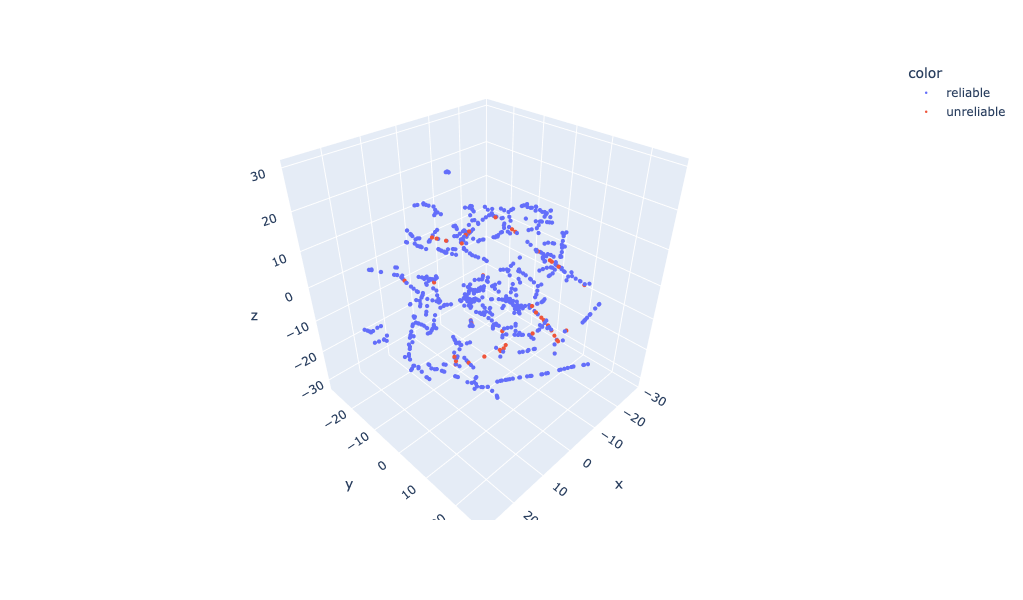

In [85]:
fig = px.scatter_3d(x=[ns[0] for ns in tsne3], y=[ns[1] for ns in tsne3], z=[ns[2] for ns in tsne3],  
                hover_name=newssources, color=reliability_color)
fig.update_traces(marker_size=2.5)
fig.update_layout(width=800, height=600)
fig.show()

## Saving data to later build a Classifier

In [91]:
hpf_repr = {ns: nse[ns].tolist() for ns in newssources}

In [94]:
len(hpf_repr)

740

In [96]:
# json.dump(hpf_repr, open("hpf_repr.json", "w"), indent=4)